# Report on "Learning Fair Scoring Functions"

- Course: Statistical Theory of Algorithmic Fairness

- Authors: Alexandre Maranhão da Rocha and Ambre Adjevi-Neglokpe

This notebook aims to reproduce step by step the experiment from the paper "Learning Fair Scoring Functions: Bipartite Ranking under ROC-based Fairness Constraints" on the Adult Income dataset. (One additional dataset?)

The notebook is organized around three sections:
1. Loading Data
2. Training the Model
3. Visualizing the Results
4. Running Experiments

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
import torch

from tqdm import tqdm

## 1. Loading Data

The Adult Income dataset can be found at https://archive.ics.uci.edu/dataset/2/adult.

In [2]:
!wget https://archive.ics.uci.edu/static/public/2/adult.zip && unzip -o adult.zip

--2024-04-02 02:40:42--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip.3’

adult.zip.3             [          <=>       ] 605.70K   275KB/s    in 2.2s    

2024-04-02 02:40:45 (275 KB/s) - ‘adult.zip.3’ saved [620237]

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         


In [3]:
df_train = pd.read_csv("adult.data", header=None)
columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week",
           "native-country", "salary"]
df_train.columns = columns
df_test = pd.read_csv("adult.test", header=None, comment="|")
df_test.columns = columns

def proc_z(Z):
    return np.array([1 if "Male" in z else 0 for z in Z])

def proc_y(Y):
    return np.array([1 if ">50K" in y else -1 for y in Y])

Z_train, Z_test = [proc_z(s["sex"]) for s in [df_train, df_test]]
Y_train, Y_test = [proc_y(s["salary"]) for s in [df_train, df_test]]

col_quanti = ["age", "education-num", "capital-gain",
              "capital-loss", "hours-per-week"]  # "fnlwgt",
col_quali = ["workclass", "education", "marital-status", "occupation",
             "relationship", "race", "sex", "native-country"]

X_train_quali = df_train[col_quali].values
X_test_quali = df_test[col_quali].values

X_train_quanti = df_train[col_quanti]
X_test_quanti = df_test[col_quanti]

quali_encoder = OneHotEncoder(categories="auto")  # drop="first")
quali_encoder.fit(X_train_quali)

X_train_quali_enc = quali_encoder.transform(X_train_quali).toarray()
X_test_quali_enc = quali_encoder.transform(X_test_quali).toarray()

X_train = np.concatenate([X_train_quali_enc, X_train_quanti], axis=1)
X_test = np.concatenate([X_test_quali_enc, X_test_quanti], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Now we have in hands our framework with $(X, Y, Z)$.

## 2. Training the Model

The model proposed by the paper is a Multilayer Perceptron (MLP) with three hidden layers and a final batch normalization. All layers have $d$ neurons, where $d$ is the dimension of the input, except for the last one, that has only one output.

In [4]:
class Model(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_features)
        self.fc2 = nn.Linear(n_features, n_features)
        self.fc_out = nn.Linear(n_features, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc_out(x)    
        x = self.bn(x)
        return x

The following functions are helpers for the training process.

In [30]:
def incomplete_auc(sc, y, B=1000):
    rel = nn.Sigmoid()
    p_filt = (y == 1)
    n_filt = ~p_filt 

    p_sc, p_y = sc[p_filt], y[p_filt]
    n_sc, n_y = sc[n_filt], y[n_filt]

    num_n = n_y.size(0)
    num_p = p_y.size(0)

    if num_n == 0 or num_p == 0:
        return torch.tensor([0], dtype=float, requires_grad=True), torch.tensor([0],  dtype=float, requires_grad=True)

    n_ind = torch.randint(0, num_n, (B,))
    p_ind = torch.randint(0, num_p, (B,))

    n_sc_inc = n_sc[n_ind]
    p_sc_inc = p_sc[p_ind]

    prod = 2 * (p_sc_inc - n_sc_inc)
    rel_auc = torch.mean(rel(-prod))
    auc = (torch.mean((prod < 0).float()) +
           0.5 * torch.mean((prod == 0).float()))
    return rel_auc, auc


def gen_batch(X, y, z, dataset_name=None, n_batch=-1, balanced=False):
    if n_batch == -1:
        return X, y, z
    selected = np.random.randint(0, len(y), n_batch)
    
    X_batch = torch.tensor(X[selected, :])
    y_batch = torch.tensor(y[selected])
    z_batch = torch.tensor(z[selected])
    
    return X_batch, y_batch,z_batch 

def compute_loss(score, y, z, coef_lagrange, c):
    rel_auc, auc = incomplete_auc(score, y) 
    
    # BPSN Condition
#     filt_0 = (y == 1) | (z == 0)
#     filt_1 = (y == 1) | (z == 1)
    filt_0 = (z == 0)
    filt_1 = (z == 1)

    rel_auc_0, auc_0 = incomplete_auc(score[filt_0], y[filt_0])
    rel_auc_1, auc_1 = incomplete_auc(score[filt_1], y[filt_1])

    rel_fair_auc = rel_auc_0 - rel_auc_1
    fair_auc = auc_0 - auc_1

    rel_cost = rel_auc + coef_lagrange*c*rel_fair_auc
    
    cost = auc + coef_lagrange*fair_auc
    return rel_cost, fair_auc

We further split the training data between training and validation.

In [37]:
def train_model(coef_lagrange):
    n_iter = 20000
    coef_regularization = 0.05
    c = 0
    history = []
    display_step = 50
    adapt_step = 0.01

    n_features = X_train.shape[1]

    model = Model(n_features)

    X_tr, X_val, y_tr, y_val, z_tr, z_val = train_test_split(
        X_train, Y_train, Z_train, test_size=0.4, random_state=42)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training Loop
    for step in tqdm(range(n_iter)):
        X_batch, y_batch, z_batch = gen_batch(X_tr, y_tr, z_tr, n_batch=100, balanced=False)

        score_batch = model(X_batch.float())

        loss, _ = compute_loss(score_batch, y_batch, z_batch, coef_lagrange, c)
        for param in model.parameters():
            loss += coef_regularization * 0.5 * param.norm(2)**2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  

        history.append(loss.item())

        if (step == n_iter - 1) or (step % display_step == 0):
            with torch.no_grad():
                X_val_batch, y_val_batch, z_val_batch = gen_batch(X_val, y_val, z_val, n_batch=100, balanced=False)
                score_val_batch = model(X_val_batch.float())
                _, val_fair_auc = compute_loss(score_val_batch, y_val_batch, z_val_batch, coef_lagrange, c)
            c = float(min(1, max(-1, c + np.sign(val_fair_auc.detach().numpy())*adapt_step)))
    return model, history

In [32]:
model, history = train_model(coef_lagrange=0.5)

  4%|▎         | 735/20000 [00:01<00:46, 413.57it/s]


KeyboardInterrupt: 

We can then visualize a moving average of the training history

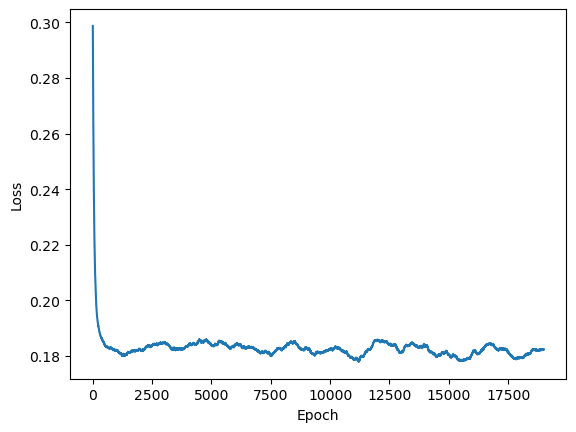

In [44]:
import matplotlib.pyplot as plt
cumsum_vec = np.cumsum(np.insert(history, 0, 0)) 
window_width = 1000
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 3. Evaluation

First, we use the trained model to calculate the scores in the test set. Then, we can calculate the False Positive and True Positive rates to plot the ROC curves. 

In [22]:
def fpr_tpr(scores, classes):
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    # indices of scores in increasing order
    ind_sort = np.argsort(scores)
    # if the scoring is perfect, all 0 would come before all 1s
    cl_sort = classes[ind_sort]
    
    # False Negative Rate (FN/(TP+FN))
    # False Negatives are all 1s that came before the threshold
    # TP+FN are all samples that have a positive real label
    fnr = cl_sort.cumsum()/n_pos
    # True Positive Rate (TP/(TP+FN))
    tpr = 1 - fnr
    # True Negative Rate (TN/(FP+TN))
    # True Negatives are all 0s that came before the threshold
    # FP+TN are all samples that have a negative real label
    tnr = (1-cl_sort).cumsum()/n_neg
    # False Positive Rate (FP/(FP+TN))
    fpr = 1 - tnr

    return fpr, tpr

def auc(scores, classes, B=None):
    if B is None:
        s = scores.reshape((-1, 1))
        y = classes.reshape((-1, 1))
        ind_0, ind_1 = np.where((y-y.transpose()) > 0)
        delta_s = s[ind_0] - s[ind_1]
    else:
        s = scores
        y = classes
        f_p = (y == 1)
        s_p, s_n = s[f_p], s[~f_p]
        delta_s = np.random.choice(s_p, B) - np.random.choice(s_n, B)
    return (delta_s > 0).mean() + 0.5*(delta_s == 0).mean()


In [33]:
def plot_evaluation(s_test, Y_test, Z_test):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    s_1 = "$ROC_{H_s^{(0)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(1)}, G_s^{(1)}}$"

    fpr_1, tpr_1 = fpr_tpr(s_test[Z_test==0], Y_test[Z_test==0])
    fpr_2, tpr_2 = fpr_tpr(s_test[Z_test==1], Y_test[Z_test==1])
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[0].plot(fpr_1, tpr_1, label=s_1, color="green", linestyle='-')
    axs[0].plot(fpr_2, tpr_2, label=s_2, color="blue", linestyle='-')
    axs[0].plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle='-')

    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"

    fpr_1, tpr_1 = fpr_tpr(s_test[Y_test!=1], Z_test[Y_test!=1])
    fpr_2, tpr_2 = fpr_tpr(s_test[Y_test==1], Z_test[Y_test==1])
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[1].plot([0, 1], [0, 1], color="grey")
    axs[1].plot(fpr_1, tpr_1, label=s_1, color="green", linestyle='-')
    axs[1].plot(fpr_2, tpr_2, label=s_2, color="blue", linestyle='-')

    for ax in axs:
        ax.set_xlabel("$FPR$")
        ax.set_ylabel("$TPR$")
        ax.grid()
        ax.legend()

    plt.tight_layout()

In [34]:
s_test = model(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
s_train = model(torch.tensor(X_train).float()).detach().numpy().ravel().astype(float)

print(f'Train AUC: {auc(s_train, Y_train)}')
print(f'Test AUC: {auc(s_test, Y_test)}')

Train AUC: 0.9001966599308506
Test AUC: 0.8935941048417972


## 4. Experiments

Now we can conduct the whole process for three different models:

1. No constraint
2. AUC contraint
3. ROC constraint

100%|██████████| 20000/20000 [00:52<00:00, 377.72it/s]


Test AUC: 89.77%
Violation: -5.09%


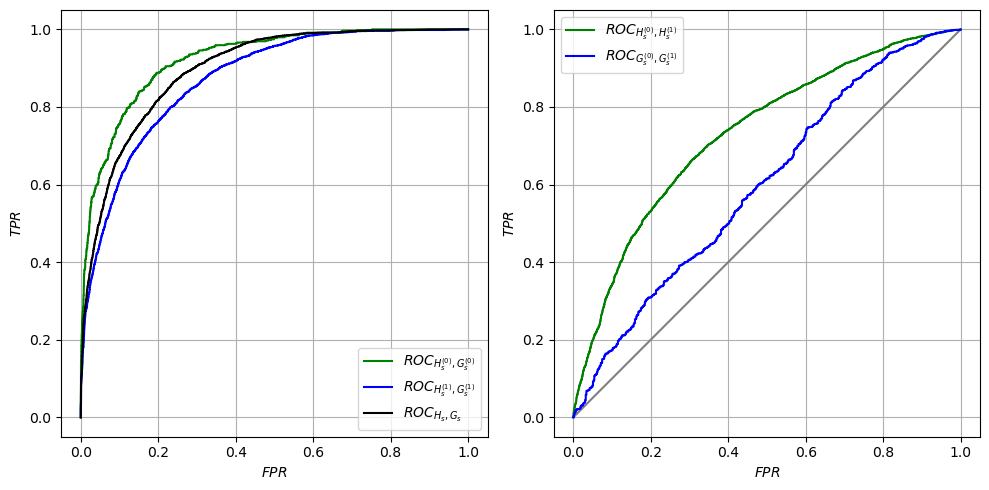

In [42]:
# 1. No constraint
model, history = train_model(coef_lagrange=0)
s_test = model(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
print(f'Test AUC: {auc(s_test, Y_test):.2%}')
print(f'Violation: {auc(s_test[Z_test==1], Y_test[Z_test==1])-auc(s_test[Z_test==0], Y_test[Z_test==0]):.2%}')
plot_evaluation(s_test, Y_test, Z_test)

100%|██████████| 20000/20000 [00:52<00:00, 377.73it/s]


Test AUC: 87.93%
Violation: 5.13%


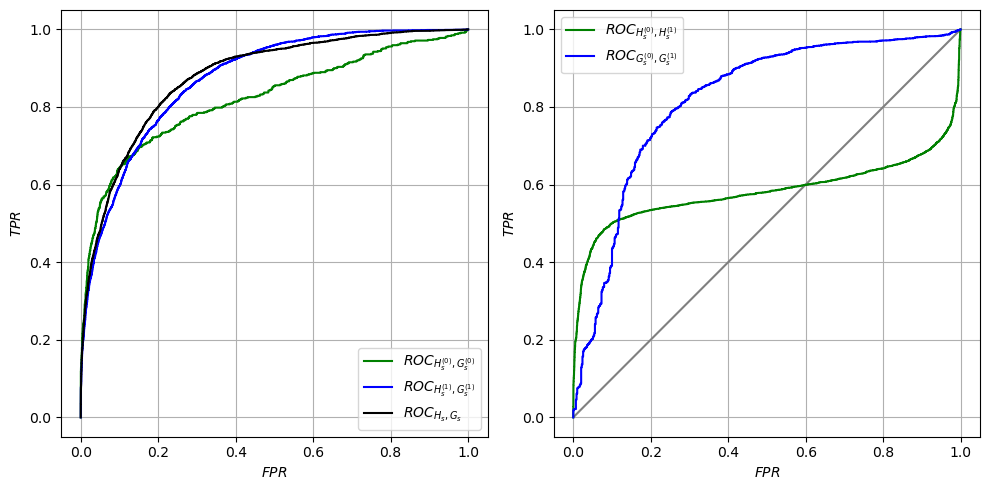

In [43]:
# 2. AUC constraint
model, history = train_model(coef_lagrange=0.25)
s_test = model(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
print(f'Test AUC: {auc(s_test, Y_test):.2%}')
print(f'Violation: {auc(s_test[Z_test==1], Y_test[Z_test==1])-auc(s_test[Z_test==0], Y_test[Z_test==0]):.2%}')
plot_evaluation(s_test, Y_test, Z_test)